In [1]:
import openpyxl
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
import copy
import scipy
import math
import random
import os

/Users/aoi/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
pathoname,a,b,c,d,mixnum = 'Pathologist A',16,17,19,20,21
#pathoname,a,b,c,d,mixnum = 'Pathologist B',10,11,13,14,15
jtime, time5, modeltime = 18,12,9
doctorname1, doctorname2, modelname = 'Pathologist A', 'Pathologist B', 'LGNet'

global pathoname, a, b, c, d, doctorname1, doctorname2, modelname

savepath = './'
filepath = "./fusion_data/ensemble_poc.xlsx"

In [3]:
def get_data(namenum, labelnum, valuenum, choicenum, jtime, time5, modeltime, filename):
    wb = openpyxl.load_workbook(filename)
    ws = wb.active
    max_row = ws.max_row
    scores_map = {}
    names = []
    timelist = []
    timename = []
    for row in range(2, max_row + 1):
        name = str(ws.cell(row, namenum).value).strip()
        score = ws.cell(row, valuenum).value
        if score == 1:
            score -= 1e-5
        if (ws.cell(row, labelnum).value) == 1:
            label = 1
        else:
            label = 0
        choice = ws.cell(row, choicenum).value
        scores_map[name] = (score, label, choice)
        names.append(name)
        timelist.extend([float(ws.cell(row, jtime).value), float(ws.cell(row, time5).value), float(ws.cell(row, modeltime).value)])
        timename.extend([doctorname1, doctorname2, modelname])
    return scores_map, names, timelist, timename

def get_doctor_multicenter_data(predictnum, scorenum, valuenum, filename):
    wb = openpyxl.load_workbook(filename)
    lg_predict = 0
    ws = wb.active
    max_row = ws.max_row
    pathologist_map = {}
    for row in range(2, max_row+1):
        name = str(ws.cell(row, 1).value).strip()
        scores = ws.cell(row, scorenum).value
        predict = ws.cell(row, predictnum).value
        
        if scores == 1:
            scores = 1
        elif scores == 2:
            scores = 2
        elif scores == 3 and predict == 0:
            scores = 3
        elif scores ==4 and predict == 1:
            scores = 4
        elif scores == 5:
            scores = 5
        elif scores == 6:
            scores = 6
        
        score = scores * 0.12 + 0.08
        label = ws.cell(row, 2).value
                
        if ws.cell(row, valuenum).value >=0.31638985:
            lg_predict = 1
            
        elif ws.cell(row, valuenum).value < 0.31638985:
            lg_predict = 0
        if lg_predict == 1 and predict == 1:
            and_predict = 1
        else:
            and_predict = 0
        if lg_predict == 1 or predict == 1:
            or_predict = 1
        else:
            or_predict = 0

        uncertainty = -((score * np.log(score)/np.log(2)) + ((1-score) * np.log(1-score)/np.log(2)))
        pathologist_map[name] = (score, label, predict, uncertainty, and_predict, or_predict)
    return pathologist_map

def get_metrics(all_labels, all_predicts):
    TP = ((all_predicts == 1) & (all_labels == 1)).sum()
    TN = ((all_predicts == 0) & (all_labels == 0)).sum()
    FN = ((all_predicts == 0) & (all_labels == 1)).sum()
    FP = ((all_predicts == 1) & (all_labels == 0)).sum()
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    return TP, TN, FN, FP, sensitivity, specificity

def collect_data(scores_map, pathologist_map, threshold=0.3):
    all_labels, all_values, p_values, p_predicts, p_uncertainties, all_values1 = [], [], [], [], [], []
    for name, scores in scores_map.items():
        doctor_scores, label, predict, uncertainty,_,_ = pathologist_map[name]
        all_labels.append(label)
        all_values.append(scores[0])
        if scores[0] <= threshold:
            all_values1.append((scores[0])/(2*threshold))
        else:
            all_values1.append((scores[0]+1-2*threshold)/(2-2*threshold))
        p_values.append(doctor_scores)
        p_predicts.append(predict)
        p_uncertainties.append(uncertainty)
    return all_labels, all_values, p_values, p_predicts, p_uncertainties, all_values1

def collect_data2(scores_map):
    all_labels, all_values, choicelist = [], [], []
    for name, values in scores_map.items():
        all_labels.append(values[1])
        all_values.append(values[0])
        choicelist.append(values[2])
    return all_labels, all_values, choicelist

def print_result(all_labels, all_values, all_predicts):
    all_auc = bootstrap_auc(all_labels, all_values)
    auc_95_ci = scipy.stats.norm.interval(0.95, np.mean(all_auc), np.std(all_auc))
    print("AUC 95% CI:")
    print("(%.4f, %.4f)" % auc_95_ci)
    TP = ((all_predicts == 1) & (all_labels == 1)).sum()
    TN = ((all_predicts == 0) & (all_labels == 0)).sum()
    FN = ((all_predicts == 0) & (all_labels == 1)).sum()
    FP = ((all_predicts == 1) & (all_labels == 0)).sum()
    lo1, hi1 = clopper_pearson(TP, TP + FN)
    print('Sensitivity 95% confidence interval: ({:.2f}, {:.2f})'.format(lo1, hi1))
    lo2, hi2 = clopper_pearson(TN, FP + TN)
    print('Specificity 95% confidence interval: ({:.2f}, {:.2f})'.format(lo2, hi2))
    lo3, hi3 = clopper_pearson(TP + TN, FP + TN + TP + FN)
    print('Acc 95% confidence interval: ({:.2f}, {:.2f})'.format(lo3, hi3))
    lo4, hi4 = clopper_pearson(TP, FP + TP)
    print('PPV 95% confidence interval: ({:.2f}, {:.2f})'.format(lo4, hi4))
    lo5, hi5 = clopper_pearson(TN, FN + TN)
    print('NPV 95% confidence interval: ({:.2f}, {:.2f})'.format(lo5, hi5))
    return ('(%f, %f)'%(lo1, hi1)), ('(%f, %f)'%(lo2, hi2))

def bootstrap_auc(all_labels, all_values, n_bootstraps=1000):
    rng_seed = 1  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(all_values), len(all_values))
        if len(np.unique(all_labels[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        score = roc_auc_score(all_labels[indices], all_values[indices])
        bootstrapped_scores.append(score)
#         print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    return bootstrapped_scores

def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

def get_uncertainty(values):
    all_values = np.column_stack((1 - values, values))
    return -np.sum(all_values * np.log(all_values), axis=1) / np.log(2)

def get_fusion_roc_value(names, all_labels, all_values, p_values, p_uncertainty):
    all_predicts = []
    correct = []
    uncertainty = get_uncertainty(all_values)
    a = uncertainty - p_uncertainty
    alpha = (1 / uncertainty) / (1 / uncertainty + 1 / p_uncertainty)
    fusion_values = []
    for i in range(len(all_values)):
        fusion_values.append(alpha[i] * all_values[i] + (1 - alpha[i]) * p_values[i])
    fusion_values = np.array(fusion_values)
    fpr, tpr, thresholds = roc_curve(all_labels, fusion_values, pos_label=1)
    min_val = 999
    min_i = 0
    for i in range(len(fpr)):
        val = abs(fpr[i] + tpr[i] - 1)
        if val < min_val:
            min_val = val
            min_i = i
    print('threshold:', thresholds[min_i], fpr[min_i], tpr[min_i])
    for i in range(len(all_labels)):
        if fusion_values[i]  >= 0.5:
            all_predicts.append(1)
        else:
            all_predicts.append(0)
        if all_predicts[i] == all_labels[i]:
            correct.append('True')
        else:
            correct.append('False')
    all_labels = np.array(all_labels)
    all_predicts = np.array(all_predicts)
    ci1, ci2 = print_result(all_labels, fusion_values, all_predicts)
    TP, TN, FN, FP,_,_ = get_metrics(all_labels, all_predicts)
    print('TP:%s TN:%s FP:%s FN:%s' %(TP, TN, FP, FN))
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    F1 = 2 * r * p / (r + p)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    Acc = (TP + TN) / (TP + TN + FP + FN)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    print('integration: precision: {:.4f}, recall: {:.4f}, F1: {:.4f}, sensitivity: {:.4f}, specificity: {:.4f}, PPV: {:.4f}, NPV: {:.4f}, ACC: {:.4f}'.format(p, r, F1, sensitivity, specificity, PPV, NPV, Acc))
    roc_auc = auc(fpr, tpr)
    print('auc:', roc_auc)
    return fpr, tpr, roc_auc, fusion_values, all_predicts, correct, p, r, F1, sensitivity, specificity, ci1, ci2

def get_fusion_roc_value_lg(all_labels, all_values, threshold=0.31638985):
    all_predicts = []
    correct = []
    fusion_values = all_values
    fpr, tpr, thresholds = roc_curve(all_labels, all_values, pos_label=1)
    min_val = 999
    min_i = 0
    for i in range(len(fpr)):
        val = abs(fpr[i] + tpr[i] - 1)
        if val < min_val:
            min_val = val
            min_i = i
    print('threshold:', thresholds[min_i], fpr[min_i], tpr[min_i])
    for i in range(len(all_labels)):
        if fusion_values[i]  >= threshold:
            all_predicts.append(1)
        else:
            all_predicts.append(0)
        if all_predicts[i] == all_labels[i]:
            correct.append('True')
        else:
            correct.append('False')
    all_labels = np.array(all_labels)
    all_predicts = np.array(all_predicts)
    all_values = np.array(all_values)
    ci1, ci2 = print_result(all_labels, all_values, all_predicts)
    TP, TN, FN, FP,_,_ = get_metrics(all_labels, all_predicts)
    
    lr_precision, lr_recall, _ = precision_recall_curve(all_labels, all_values, pos_label=1)
    pr_auc = auc(lr_recall, lr_precision)
    print('PR AUC', pr_auc)

    print('TP:%s TN:%s FP:%s FN:%s' %(TP, TN, FP, FN))
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    F1 = 2 * r * p / (r + p)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    Acc = (TP + TN) / (TP + TN + FP + FN)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    print('integration: precision: {:.4f}, recall: {:.4f}, F1: {:.4f}, sensitivity: {:.4f}, specificity: {:.4f}, PPV: {:.4f}, NPV: {:.4f}, ACC: {:.4f}'.format(p, r, F1, sensitivity, specificity, PPV, NPV, Acc))
    roc_auc = auc(fpr, tpr)
    print('auc:', roc_auc)
    return fpr, tpr, roc_auc, fusion_values, all_predicts, correct, p, r, F1, sensitivity, specificity, ci1, ci2

def get_fusion_roc_value_mix(names, all_labels, all_values, p_values, p_uncertainty, choicelist):
    all_predicts = []
    correct = []
    uncertainty = get_uncertainty(all_values)
    a = uncertainty - p_uncertainty
    alpha = (1 / uncertainty) / (1 / uncertainty + 1 / p_uncertainty)
    fusion_values = []
    for i in range(len(all_values)):
        if choicelist[i] == 0:
            fusion_values.append(p_values[i])
        else:
            fusion_values.append(alpha[i] * all_values[i] + (1 - alpha[i]) * p_values[i])
    fusion_values = np.array(fusion_values)
    fpr, tpr, thresholds = roc_curve(all_labels, fusion_values, pos_label=1)
    min_val = 999
    min_i = 0
    for i in range(len(fpr)):
        val = abs(fpr[i] + tpr[i] - 1)
        if val < min_val:
            min_val = val
            min_i = i
    print('threshold:', thresholds[min_i], fpr[min_i], tpr[min_i])
    for i in range(len(all_labels)):
        if fusion_values[i]  >= 0.5:
            all_predicts.append(1)
        else:
            all_predicts.append(0)
        if all_predicts[i] == all_labels[i]:
            correct.append('True')
        else:
            correct.append('False')
    all_labels = np.array(all_labels)
    all_predicts = np.array(all_predicts)
    ci1, ci2 = print_result(all_labels, fusion_values, all_predicts)
    TP, TN, FN, FP,_,_ = get_metrics(all_labels, all_predicts)
    print('TP:%s TN:%s FP:%s FN:%s' %(TP, TN, FP, FN))
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    F1 = 2 * r * p / (r + p)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    Acc = (TP + TN) / (TP + TN + FP + FN)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    print('integration: precision: {:.4f}, recall: {:.4f}, F1: {:.4f}, sensitivity: {:.4f}, specificity: {:.4f}, PPV: {:.4f}, NPV: {:.4f}, ACC: {:.4f}'.format(p, r, F1, sensitivity, specificity, PPV, NPV, Acc))
    roc_auc = auc(fpr, tpr)
    print('auc:', roc_auc)
    return fpr, tpr, roc_auc, fusion_values, all_predicts, correct, p, r, F1, sensitivity, specificity, ci1, ci2

def plot_auc(names, all_labels, all_values, all_values1, pj_values, pj_predicts, pj_uncertainties, ps_values, ps_predicts, ps_uncertainties, choicelist):
    TPj, TNj, FNj, FPj, sensitivityj, specificityj = get_metrics(all_labels, pj_predicts)
    TPs, TNs, FNs, FPs, sensitivitys, specificitys = get_metrics(all_labels, ps_predicts)
    fpr, tpr, threshold = roc_curve(all_labels, all_values, pos_label=1)
    roc_auc = auc(fpr, tpr)
    precisions, recalls, f1s, sensitivitys, specificitys, aurocs, ci1s, ci2s = [],[],[],[],[],[],[],[]
    print('\n%s'% pathoname)
    fpr_fusionj, tpr_fusionj, roc_auc_fusionj4, fusion_values10, all_predicts10, correct10, p4, r4, F14, sensitivity4, specificity4, ci14, ci24 = get_fusion_roc_value_lg(all_labels, pj_values, threshold=0.5)
    print('\n%s after'% pathoname)
    fpr_fusionj, tpr_fusionj, roc_auc_fusionj4, fusion_values10, all_predicts10, correct10, p4, r4, F14, sensitivity6, specificity6, ci14, ci24 = get_fusion_roc_value_lg(all_labels, ps_values, threshold=0.5)
    
    print('\n%s'% pathoname)
    print('method 1/uncertainty')
    fpr_fusionj, tpr_fusionj, roc_auc_fusionj, fusion_values1, all_predicts1, correct1, p1, r1, F11, sensitivity1, specificity1, ci11, ci21 = get_fusion_roc_value(names, all_labels, all_values1, pj_values, pj_uncertainties)
    print('\n%s after'% pathoname)
    print('method 1/uncertainty')
    fpr_fusions, tpr_fusions, roc_auc_fusions, fusion_values2, all_predicts2, correct2, p5, r5, F15, sensitivity5, specificity5, ci15, ci25 = get_fusion_roc_value(names, all_labels, all_values1, ps_values, ps_uncertainties)
    
    print('\n%s after'% pathoname)
    print('mix')
    fpr_fusions1, tpr_fusions1, roc_auc_fusions1, fusion_values3, all_predicts3, correct3, p5, r5, F15, sensitivity5, specificity5, ci15, ci25 = get_fusion_roc_value_mix(names, all_labels, all_values1, ps_values, ps_uncertainties, choicelist)

    fpr_fusions1, tpr_fusions1, roc_auc_fusions1, fusion_values3, all_predicts3, correct3, p5, r5, F15, sensitivity5, specificity5, ci15, ci25 = get_fusion_roc_value_lg(all_labels, fusion_values3, threshold = 0.5)
    df1 = pd.DataFrame({'name': names,
                        'predicts_before': all_predicts1,
                        'values_before': fusion_values1,
                        'predicts_after': all_predicts2,
                        'values_after': fusion_values2,
                        'predicts_mix': all_predicts3,
                        'values_mix': fusion_values3
                           })
    
    #with PdfPages(filename) as export_pdf:
    plt.figure(figsize=(9, 9))
    lw = 2
    ax = plt.plot(fpr, tpr, color='orange', marker='',
             lw=lw, label='LGNet (AUROC = %0.3f)' % roc_auc)
    plt.scatter(1 - specificity4, sensitivity4, color = 'purple', marker='v', label='%s (unassisted)' % pathoname, s=50)
    plt.scatter(1 - specificity6, sensitivity6, color = 'purple', marker='s', label='%s (assisted)'% pathoname, s=50)
    plt.plot(fpr_fusions1, tpr_fusions1, color='green', marker='',
             lw=lw, label='L-P%s combination (AUROC = %0.3f)' % (pathoname[-1], roc_auc_fusions1))
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - specificity',{'family': 'Arial', 'size' : 30, 'weight': 'semibold'})
    plt.ylabel('Sensitivity',{'family': 'Arial', 'size' : 30, 'weight': 'semibold'})
    plt.xticks(fontproperties = 'Arial', size = 25, weight='semibold')
    plt.yticks(fontproperties = 'Arial', size = 25, weight='semibold')

    plt.title('')
    plt.legend(loc="lower right", prop = {'family': 'Arial', 'size' : 15, 'weight': 'semibold'})
    #plt.savefig(os.path.join(savepath, '%s_roc_poc_mix.eps'%pathoname), format = 'eps',transparent=True)
    return precisions, recalls, f1s, sensitivitys, specificitys, ci1s, ci2s   

lgnet
threshold: 0.26963057327614 0.01639344262295082 1.0
AUC 95% CI:
(0.9889, 1.0059)
Sensitivity 95% confidence interval: (0.42, 1.00)
Specificity 95% confidence interval: (0.91, 1.00)
Acc 95% confidence interval: (0.90, 1.00)
PPV 95% confidence interval: (0.42, 1.00)
NPV 95% confidence interval: (0.91, 1.00)
PR AUC 0.9808673469387755
TP:6 TN:60 FP:1 FN:1
integration: precision: 0.8571, recall: 0.8571, F1: 0.8571, sensitivity: 0.8571, specificity: 0.9836, PPV: 0.8571, NPV: 0.9836, ACC: 0.9706
auc: 0.9976580796252927

Pathologist A
threshold: 0.44 0.21311475409836064 0.5714285714285714
AUC 95% CI:
(0.7043, 0.9438)
Sensitivity 95% confidence interval: (0.18, 0.90)
Specificity 95% confidence interval: (0.72, 0.92)
Acc 95% confidence interval: (0.70, 0.89)
PPV 95% confidence interval: (0.08, 0.58)
NPV 95% confidence interval: (0.85, 0.99)
PR AUC 0.37478627814762266
TP:4 TN:51 FP:10 FN:3
integration: precision: 0.2857, recall: 0.5714, F1: 0.3810, sensitivity: 0.5714, specificity: 0.8361, 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUC 95% CI:
(1.0000, 1.0000)
Sensitivity 95% confidence interval: (0.59, 1.00)
Specificity 95% confidence interval: (0.94, 1.00)
Acc 95% confidence interval: (0.95, 1.00)
PPV 95% confidence interval: (0.59, 1.00)
NPV 95% confidence interval: (0.94, 1.00)
PR AUC 1.0
TP:7 TN:61 FP:0 FN:0
integration: precision: 1.0000, recall: 1.0000, F1: 1.0000, sensitivity: 1.0000, specificity: 1.0000, PPV: 1.0000, NPV: 1.0000, ACC: 1.0000
auc: 1.0


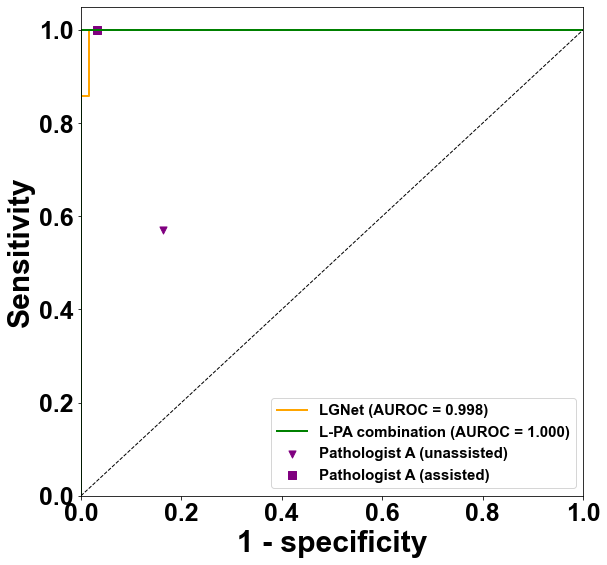

In [4]:
if __name__ == '__main__':

    scores_map, names, timelist, timename = get_data(1, 2, 4, mixnum, jtime, time5, modeltime, filepath)
    all_labels, all_values, choicelist = collect_data2(scores_map)
    print('lgnet')
    fpr_fusionj, tpr_fusionj, roc_auc_fusionj4, fusion_values10, all_predicts10, correct10, p4, r4, F14, sensitivity4, specificity4, ci14, ci24 = get_fusion_roc_value_lg(all_labels, all_values)

    pathologist_maps = get_doctor_multicenter_data(b,a,4,filepath)
    pathologist_maps2 = get_doctor_multicenter_data(d,c,4,filepath)

    all_labels, all_values, ps_values, ps_predicts, ps_uncertainties, all_values1 = collect_data(scores_map, pathologist_maps)
    all_labels, all_values, ps_values1, ps_predicts1, ps_uncertainties1, all_values1 = collect_data(scores_map, pathologist_maps2)

    precisions1, recalls1, f1s1, sensitivitys1, specificitys1, ci1s1, ci2s1 = plot_auc(names, np.array(all_labels), np.array(all_values), np.array(all_values1), np.array(ps_values), 
             np.array(ps_predicts), np.array(ps_uncertainties),np.array(ps_values1), 
             np.array(ps_predicts1), np.array(ps_uncertainties1), choicelist)


In [5]:
data = pd.DataFrame({'time':timelist,
                   'timename':timename})

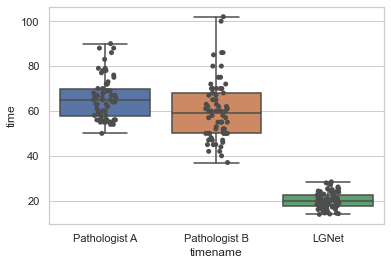

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(style="whitegrid")

sns.boxplot(x="timename", y="time", data=data, whis=np.inf)
sns.stripplot(x="timename", y="time", data=data,
              jitter=True, color=".3")
plt.show()
